# Exercise

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus:

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

These are some (synthetic but realistic) supernova data:

In [1]:
from astroML.datasets import generate_mu_z
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
import astroML

%matplotlib inline
%config InlineBackend.figure_format='retina'

C:\Users\beasa\anaconda3\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


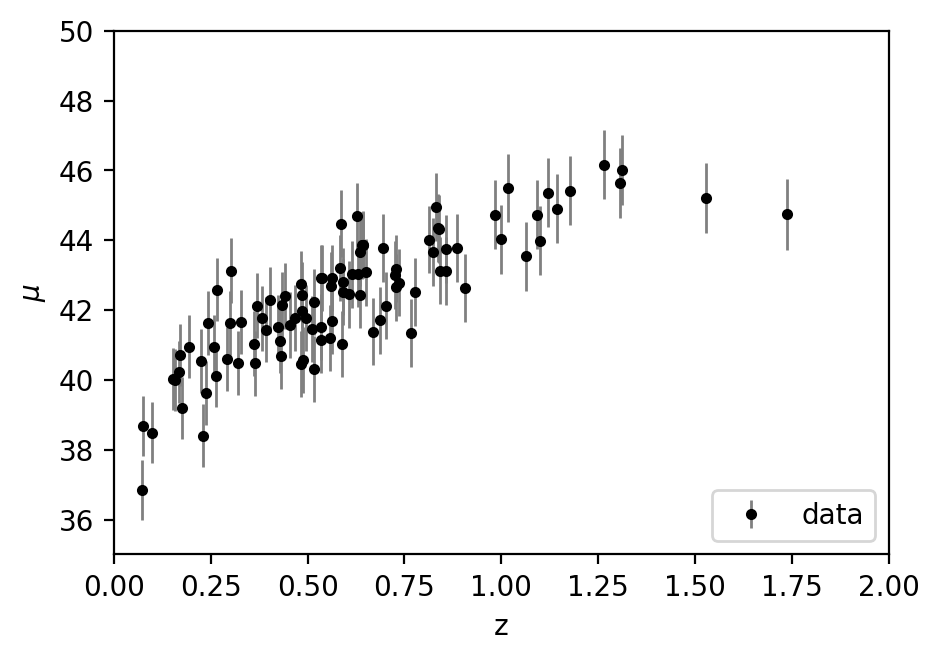

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

####  Tasks

- First, explore fitting this data with the tecniques we have seen. Start from linear regression and polynomial regression. For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best? In what cases are you underfitting the data? In what cases are you overfitting the data?
- Now split the data into training and validation sets.
- Implement a cross-validation procedure.
- Pick the best! Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

##### Linear regression

I can fit with linear regression in two ways: the first one is by computing the covariance matrix ($C$), the design matrix ($M$) and the parameters of the fit with the analytical expressions, the second one consists in using the method $LinearRegression()$.

In [3]:
# x = z_sample and y = mu_sample (dmu = y uncertainties)

C = np.identity(len(z_sample))*dmu**2*len(dmu)  # dmu is the error on the measurement, i.e., sigma=dmu*np.sqrt(N)
M = np.column_stack((np.ones(len(z_sample)), z_sample))
# M.T = transpose of M, np.linalg.pinv(C) = inverse of C, np.dot = multiplication between matrices
theta_a = np.dot(np.dot(M.T, np.linalg.pinv(C)), M)
theta_b = np.dot(np.dot(M.T, np.linalg.pinv(C)), mu_sample)

theta = np.dot(np.linalg.pinv(theta_a), theta_b)

In [4]:
print('The parameters are: ', theta)
print(f'Linear Regression returns: y = {theta[1]:.2f}x + {theta[0]:.2f}')

The parameters are:  [39.48384602  4.76438865]
Linear Regression returns: y = 4.76x + 39.48


The resulting plot is:

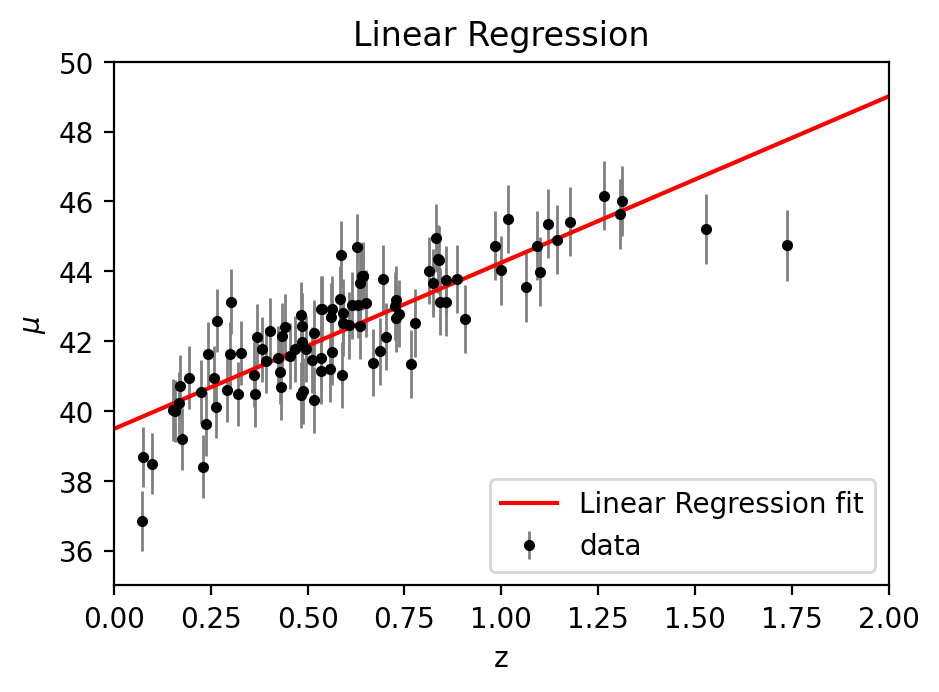

In [5]:
xgrid = np.linspace(0, 2, 100)
ygrid = theta[1]*xgrid+theta[0]
fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(xgrid, ygrid, color='red', label='Linear Regression fit')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Linear Regression')
plt.show()

In [6]:
lin_reg = LinearRegression()
lin_reg.fit(z_sample.reshape(-1, 1), mu_sample.reshape(-1, 1), sample_weight=1.0)

theta_B = lin_reg.intercept_
theta_A = lin_reg.coef_

print('The parameters are: ', theta_B[0], theta_A[0][0])
print(f'Linear Regression returns: y = {theta_A[0][0]:.2f}x + {theta_B[0]:.2f}')
ygrid2 = lin_reg.predict(xgrid.reshape(-1, 1))

The parameters are:  39.56505554722625 4.647118479591295
Linear Regression returns: y = 4.65x + 39.57


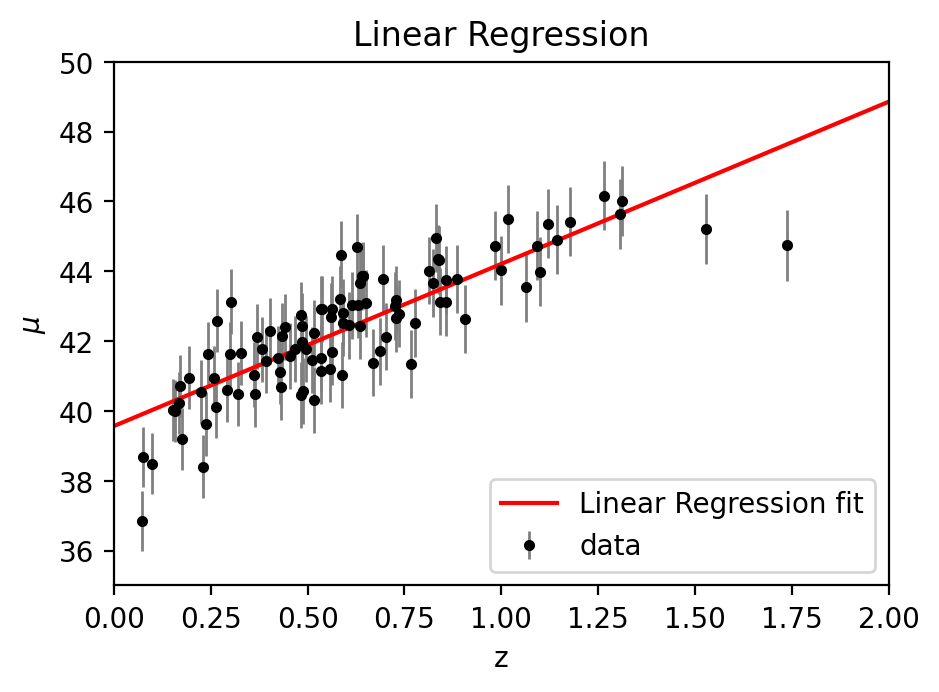

In [7]:
fig = plt.figure(figsize=(5, 3.4))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(xgrid, ygrid2, color='red', label='Linear Regression fit')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Linear Regression')
plt.show()

I want now to make a comparison between the two procedures. 

In [8]:
thetaA = theta_A[0][0]
thetaB = theta_B[0]

print(f'Analytical computation: y = {theta[1]:.2f}x + {theta[0]:.2f}')  # computed with the matrices
print(f'Method computation: y = {thetaA:.2f}x + {thetaB:.2f}')  # computed with LinearRegression() method

Analytical computation: y = 4.76x + 39.48
Method computation: y = 4.65x + 39.57


##### Polynomial regression

To start, I initialize two arrays, one of degrees ($degree$) that I want to use for the fit, and one of the resulting coefficients ($coefficients$).

In [9]:
degree = np.arange(2, 17)  # values in [2, 16]
coefficients = []

For each value of the degree I compute the polynomial regression and I plot the corresponding results.

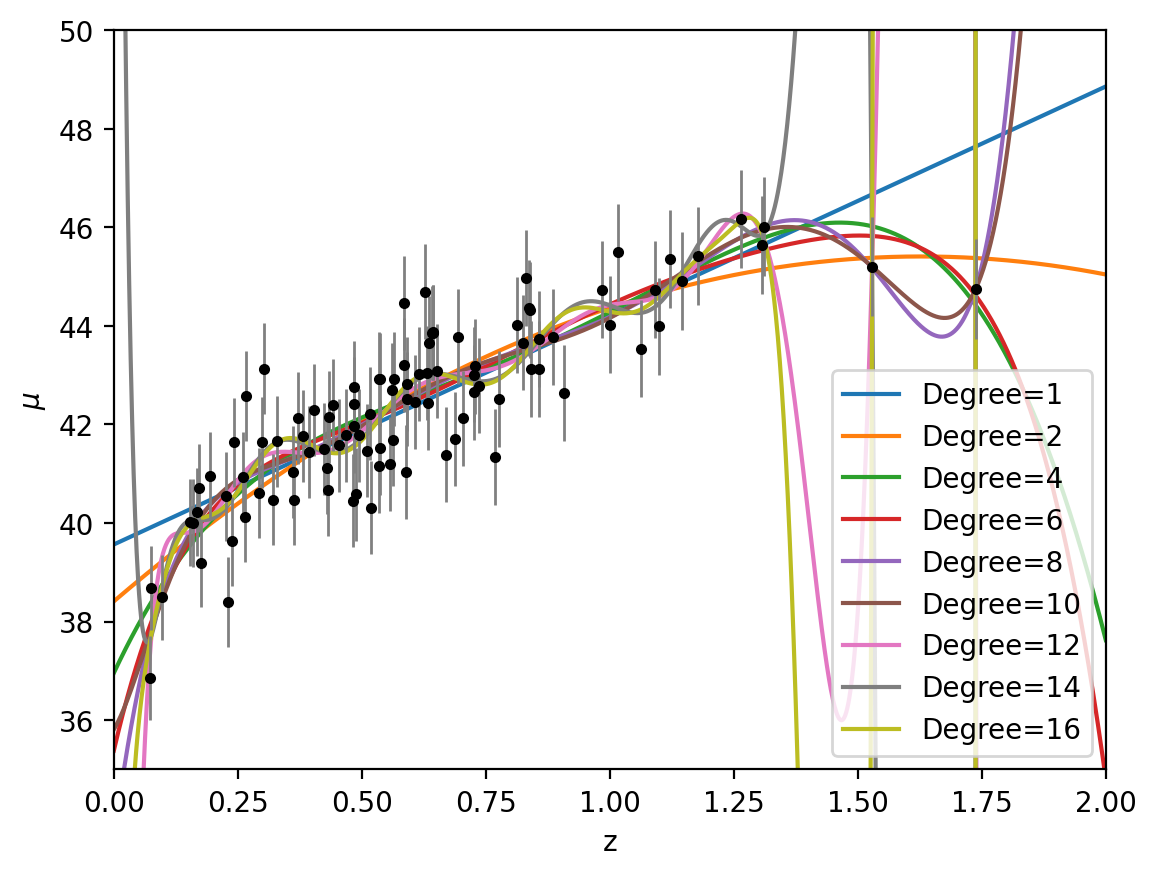

In [10]:
plt.plot(xgrid, ygrid2, label='Degree=1')
Xgrid = np.linspace(0, 2, 2000)

for d in degree:
    Model = PolynomialRegression(d)
    Model.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    y_pred = Model.predict(Xgrid[:, np.newaxis])
    coefficients.append(Model.coef_)
    if d%2==0:
        plt.plot(Xgrid, y_pred, label='Degree='+str(d))  # plot only the fits with a even degree (to have a clear plot)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

In the linear regression case I am underfitting the data, while in the case of high degrees (i.e., $degree>8$) I am overfitting the data. Therefore, the best model for these data can be the one with a degree equal to $4$ or the one with the degree equal to $6$.

To make a cross validation analysis, I split the data set into training and validation sets. Then I initialize the linear regression method and I fit the training data.

In [11]:
z_tr, z_val, mudmu_tr, mudmu_val = sklearn.model_selection.train_test_split(z_sample[:, np.newaxis], 
                                                                      np.array([mu_sample, dmu]).T, train_size=0.65)

mu_tr, dmu_tr = mudmu_tr.T
mu_val, dmu_val = mudmu_val.T

In [12]:
clf = LinearRegression()
clf.fit(z_tr, mu_tr, dmu_tr)

LinearRegression()

In what follows, I initialize the functions that return the training and CV rms errors for linear regression.

In [13]:
def TrError(cl, zt, mut):
    err_tr = np.sqrt(np.sum((mut-cl.predict(zt))**2)/len(zt))
    return err_tr

def ValError(cl, zv, muv):
    err_val = np.sqrt(np.sum((muv-cl.predict(zv))**2)/len(zv))
    return err_val

In [14]:
error_tr = TrError(clf, z_tr, mu_tr)
error_val = ValError(clf, z_val, mu_val)

print(f'Training and validation rms errors for linear regression: {error_tr:.3f} and {error_val:.3f}')

Training and validation rms errors for linear regression: 0.992 and 0.977


For polynomial regression, instead:

In [15]:
error_tr1 = []
error_val1 = []

for d in degree:
    clf1 = PolynomialRegression(d)
    clf1.fit(z_tr, mu_tr, dmu_tr)
    
    error_tr1.append(TrError(clf1, z_tr, mu_tr))
    error_val1.append(ValError(clf1, z_val, mu_val))

In [16]:
Degree = np.copy(degree)
Degree = np.insert(Degree, 0, 1)
error_tr1 = np.insert(error_tr1, 0, error_tr)
error_val1 = np.insert(error_val1, 0, error_val)

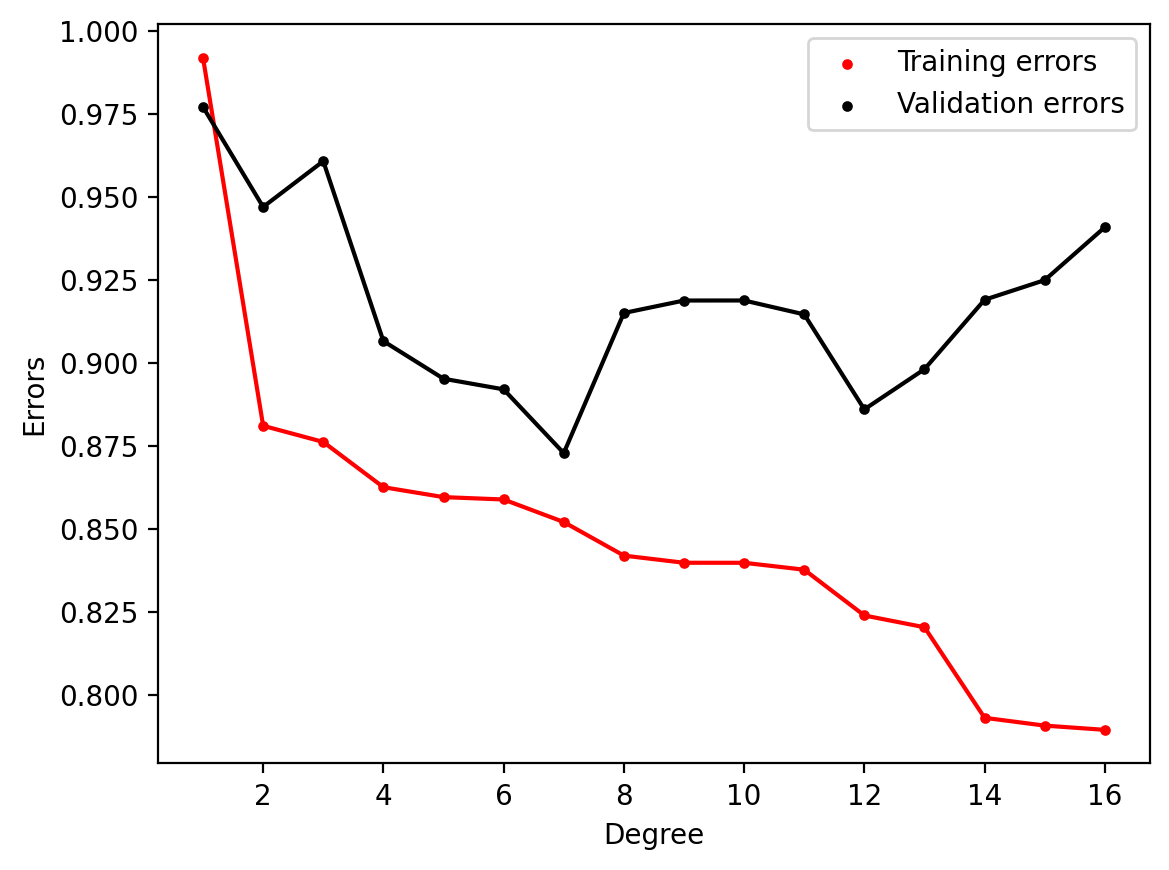

In [17]:
plt.scatter(Degree, error_tr1, color='red', label='Training errors', s=8)
plt.scatter(Degree, error_val1, color='black', label='Validation errors', s=8)
plt.plot(Degree, error_tr1, color='red')
plt.plot(Degree, error_val1, color='black')
plt.xlabel('Degree')
plt.ylabel('Errors')
plt.legend()
plt.show()

For:
1. small degrees ($deg \leq 3$): both validation error and training error are high. The model is underfitting the data.
2. high degrees ($deg > 6$): the training error is much smaller then the validation one. The model is overfitting the data.

##### Basis function regression and kernel regression

In [18]:
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

Let's start with basis function regression, in particular I want to use Gaussian functions.

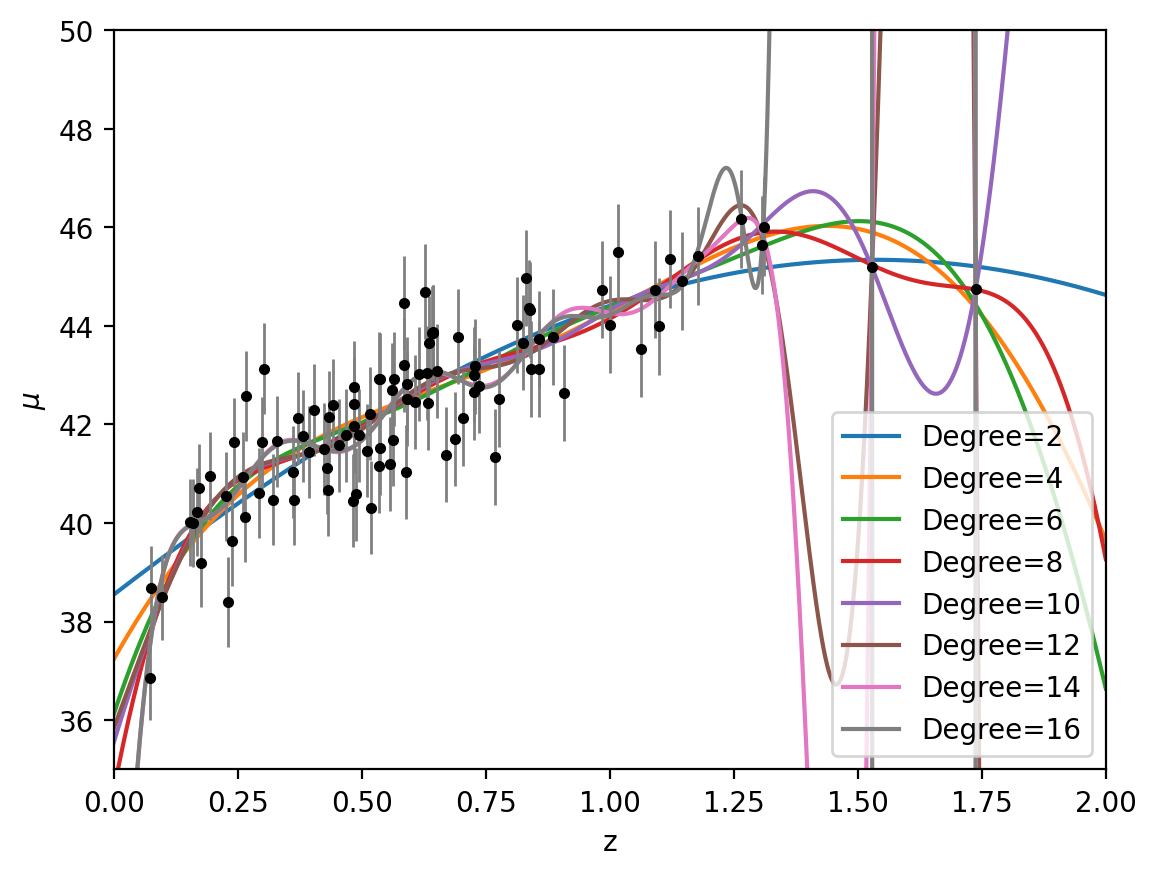

In [19]:
for d in degree:
    # mean positions of the d Gaussians in the model
    Mu = np.linspace(0, 2, d)[:, None]
    # widths of the Gaussians
    Sigma = Mu[1]-Mu[0]
    
    model = astroML.linear_model.BasisFunctionRegression('gaussian', mu=Mu, sigma=Sigma)
    model.fit(z_sample.reshape(-1, 1), mu_sample, dmu)
    Y_pred = model.predict(Xgrid.reshape(-1, 1))
    
    if d%2==0:
        plt.plot(Xgrid, Y_pred, label='Degree='+str(d))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

For kernel regression instead:

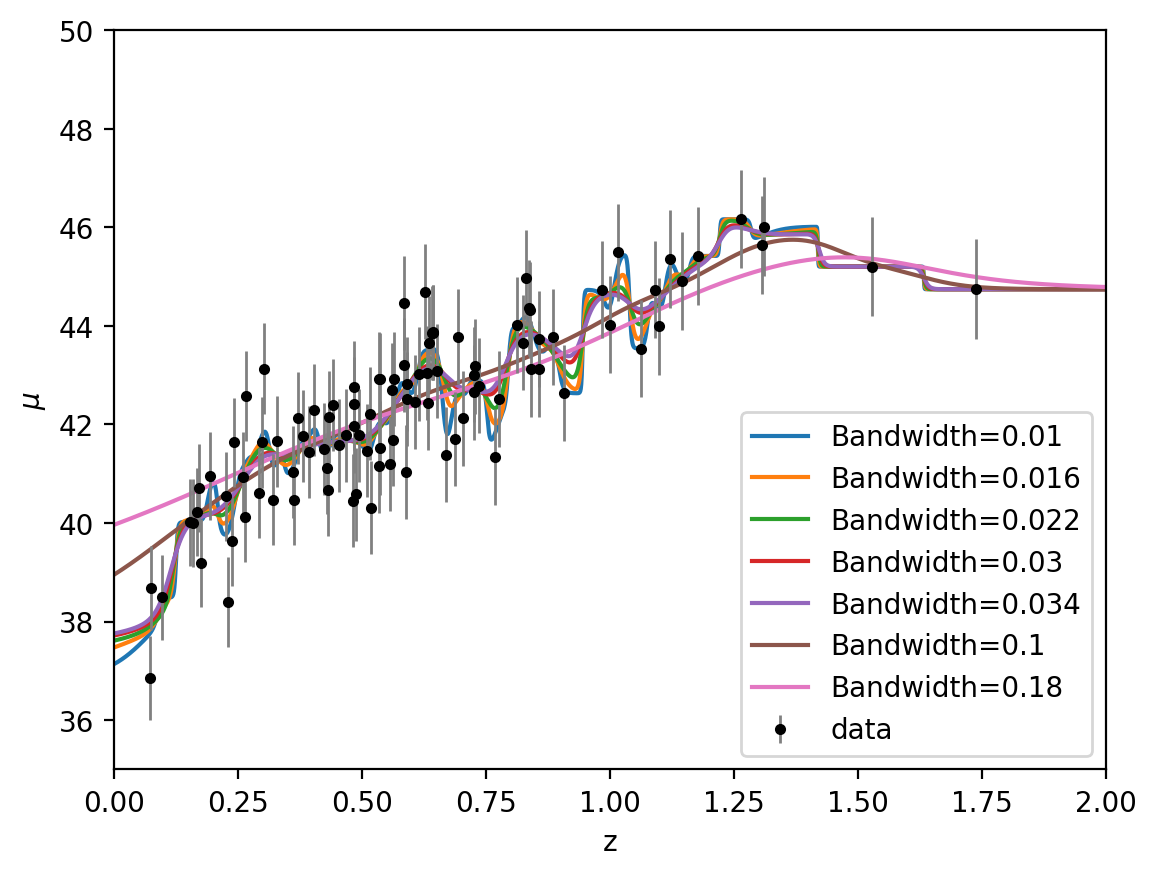

In [20]:
bandwidth = [0.010, 0.013, 0.016, 0.019, 0.022, 0.027, 0.030, 0.034, 0.10, 0.18]

for b in bandwidth:
    model = astroML.linear_model.NadarayaWatson('gaussian', b)
    model.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    Y_pred2 = model.predict(Xgrid[:, np.newaxis])
    
    if (b*1000)%2==0:
        plt.plot(Xgrid, Y_pred2, label='Bandwidth='+str(b))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

I want now to change the number of training and validation points. To do that, I initialize an array of percentages for the training set size.

In [21]:
trainSize = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

In [22]:
z_tr2 = []
z_val2 = [] 
mudmu_tr2 = []
mudmu_val2 = []
mu_tr2 = []
dmu_tr2 = []
mu_val2 = []
dmu_val2 = []

for tS in trainSize:
    var1, var2, var3, var4 = sklearn.model_selection.train_test_split(z_sample[:, np.newaxis], 
                                                                      np.array([mu_sample, dmu]).T, train_size=tS)
    
    var5, var6 = var3.T
    var7, var8 = var4.T
    
    z_tr2.append(var1)
    z_val2.append(var2)
    mu_tr2.append(var5)
    dmu_tr2.append(var6)
    mu_val2.append(var7)
    dmu_val2.append(var8)

I want now to compare the different results for different train sizes. In the first plot I use $trainSize[3]$ while in the second one $trainSize[7]$ and in the third one $trainSize[1]$.

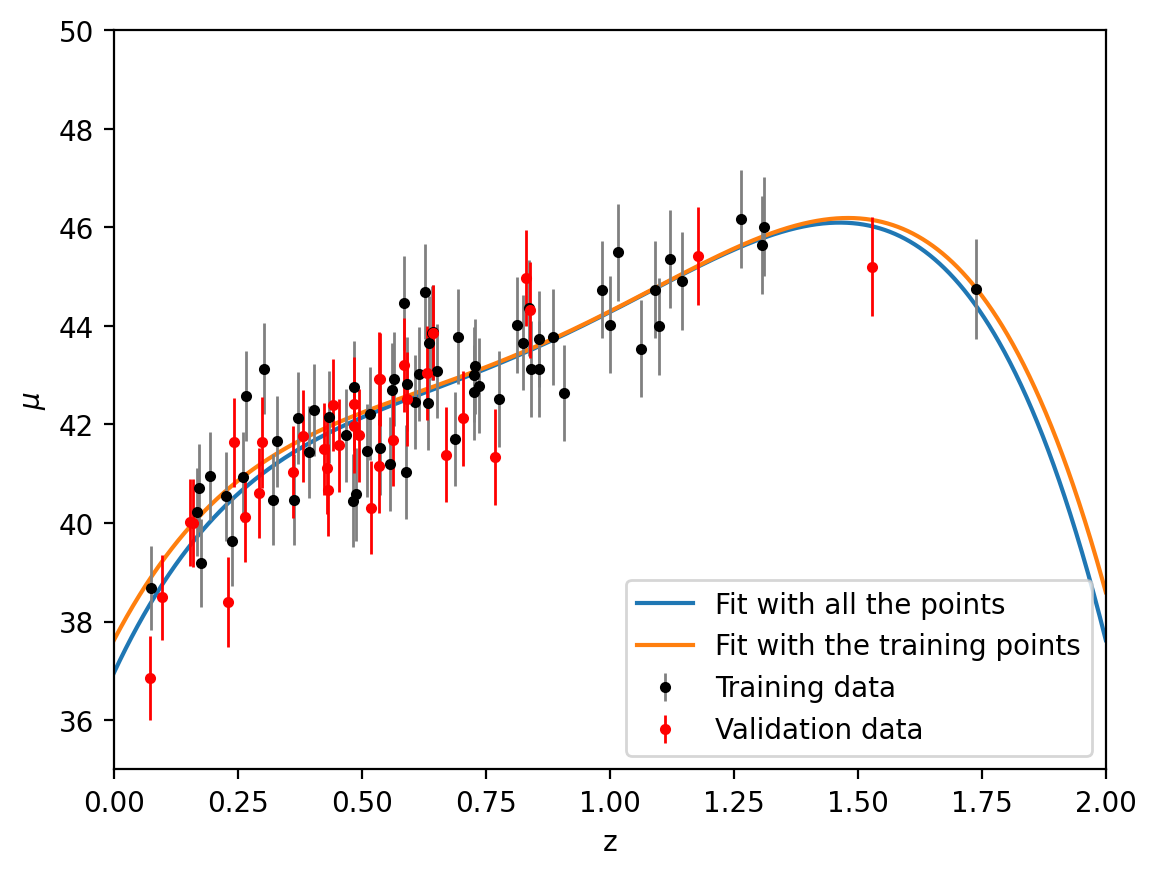

In [23]:
bestD = 4  # degree = 4 -> best fit

Model1 = PolynomialRegression(bestD)
Model1.fit(z_sample[:, np.newaxis], mu_sample, dmu)
y_pred1 = Model1.predict(Xgrid[:, np.newaxis])
Model2 = PolynomialRegression(bestD)
Model2.fit(z_tr2[3], mu_tr2[3], dmu_tr2[3])
y_pred2 = Model2.predict(Xgrid[:, np.newaxis])
    
plt.plot(Xgrid, y_pred1, label='Fit with all the points')
plt.plot(Xgrid, y_pred2, label='Fit with the training points')

plt.errorbar(z_tr2[3], mu_tr2[3], dmu_tr2[3], fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.errorbar(z_val2[3], mu_val2[3], dmu_val2[3], fmt='.k', ecolor='red', markerfacecolor='red', 
             markeredgecolor='red', lw=1, label='Validation data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

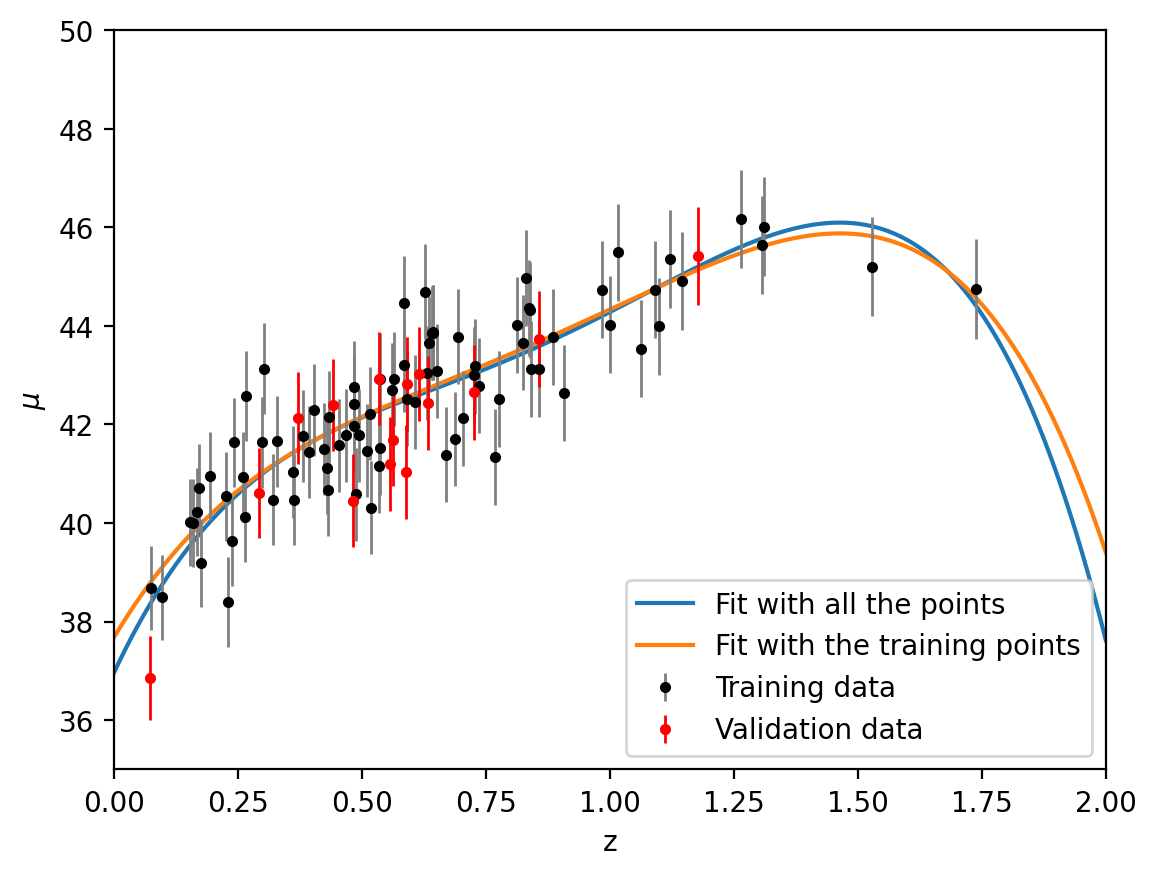

In [24]:
Model2.fit(z_tr2[7], mu_tr2[7], dmu_tr2[7])
y_pred2 = Model2.predict(Xgrid[:, np.newaxis])
    
plt.plot(Xgrid, y_pred1, label='Fit with all the points')
plt.plot(Xgrid, y_pred2, label='Fit with the training points')

plt.errorbar(z_tr2[7], mu_tr2[7], dmu_tr2[7], fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.errorbar(z_val2[7], mu_val2[7], dmu_val2[7], fmt='.k', ecolor='red', markerfacecolor='red', 
             markeredgecolor='red', lw=1, label='Validation data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

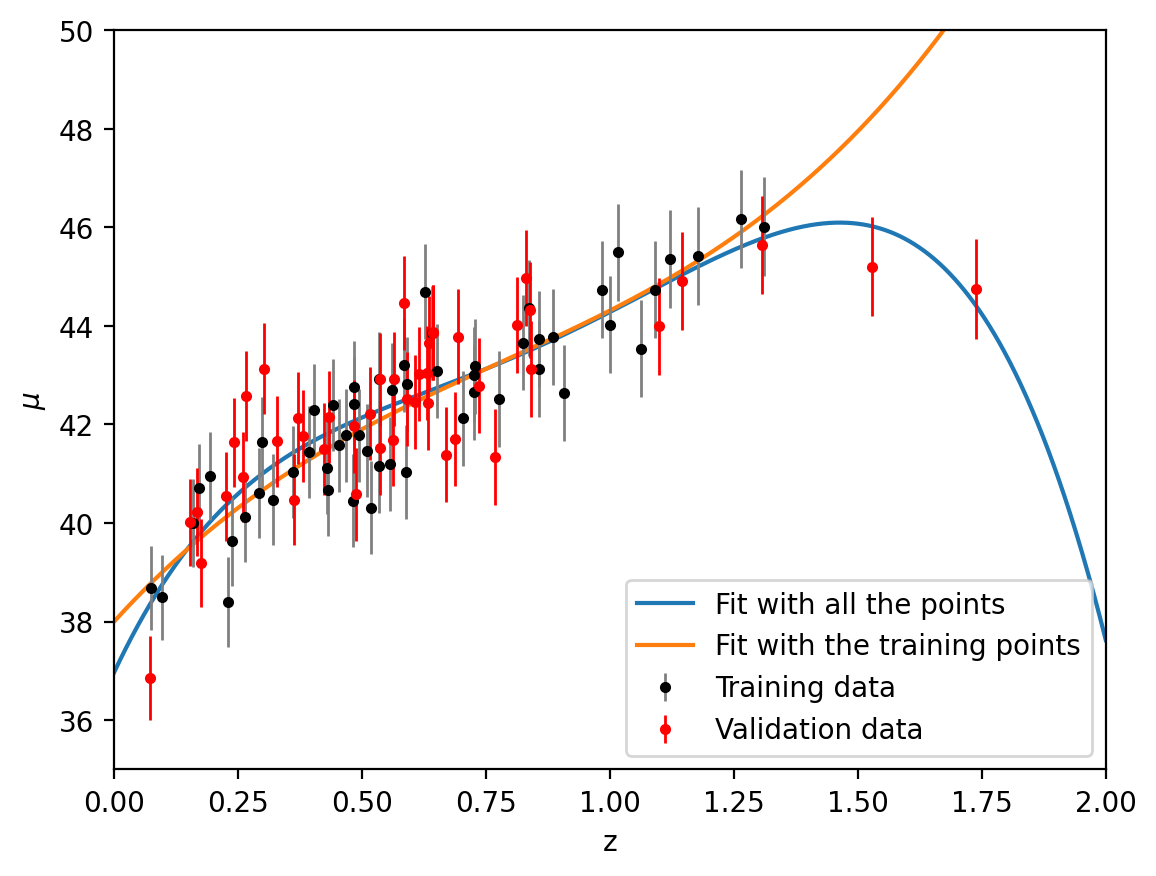

In [25]:
Model2.fit(z_tr2[1], mu_tr2[1], dmu_tr2[1])
y_pred2 = Model2.predict(Xgrid[:, np.newaxis])
    
plt.plot(Xgrid, y_pred1, label='Fit with all the points')
plt.plot(Xgrid, y_pred2, label='Fit with the training points')

plt.errorbar(z_tr2[1], mu_tr2[1], dmu_tr2[1], fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.errorbar(z_val2[1], mu_val2[1], dmu_val2[1], fmt='.k', ecolor='red', markerfacecolor='red', 
             markeredgecolor='red', lw=1, label='Validation data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()